In [47]:
import numpy as np
import matplotlib.pyplot as plt
seed = 1923
print (f"User seed is set to {seed}")

User seed is set to 1923


In [48]:
print ("""Make sure to check later which 
    functions you can use and which you have to write yourself""")
print ("\n")

print ("Question: can we use np arrays for division etc?")

Make sure to check later which 
    functions you can use and which you have to write yourself


Question: can we use np arrays for division etc?


# Question 1 Preparing some useful routines

In [49]:
def fac(k):
    """Returns factorial of k. Note: 0! is defined as 1"""
    if k == 0:
        return 1
    ans = k
    for x in range(1,k):
        ans *= x
    return ans

In [50]:
def poisson_probability(k,lambd):
    """
    Returns the Poisson probability, i.e., the probability of 'k' 
    occurences if 'lambd' is the occurence rate, per interval. 
    """
    return (lambd**k * np.exp(-1*lambd))/(fac(k))

## Output $P_{\lambda}(k)$ to at least 6 significant digits for following values

In [51]:
# Output P_{\lambda}(k) to at least 6 significant digits for these values
lambdas = [1,5,3,2.6]
ks = [0,10,20,40]

for k, lambd in zip(ks, lambdas):
    print(f'P_{lambd}({k}) = {poisson_probability(k,lambd):.5e}')


P_1(0) = 3.67879e-01
P_5(10) = 1.81328e-02
P_3(20) = 7.13538e-11
P_2.6(40) = 3.61512e-33


### Write a random number generator that returns a random floating-point number between 0 and 1. At minimum, use some combination of an (M)LCG and a 64-bit XOR-shift

In [52]:
class RandomGenerator(object):
    """
    Random generator should be an object because it maintains
    internal state between calls.
    """
    def __init__(self, seed):
        # make sure the everyhing is an unsigned 64 bit integer
        dtyp = np.uint64
        # the seed for the LGC
        self.X1 = dtyp(seed)
        # the seed for the XORshift
        self.X2 = dtyp(seed)
        
        self.max_value = dtyp(2**64 - 1)
        
        # LCG values from Numerical Recipies
        self.a = dtyp(1664525)
        self.c = dtyp(1013904223)
        self.m = dtyp(2**32)
        
        # 64 bit XOR shift values from Numerical Recipies
        self.a1, self.a2, self.a3 = dtyp(21), dtyp(35), dtyp(4)
        
    def lincongen(self, X):    
        return (self.a*X+self.c) % self.m

    def XORshift64(self, X):
        if X == 0:
            raise ValueError("Seed cannot be zero")
        X = X ^ (X >> self.a1)
        X = X ^ (X << self.a2)
        X = X ^ (X >> self.a3)
        
        return X
    
    def get_randomnumber(self):
        """
        Combine LCG and XORshift to produce random float 
        between 0 and 1
        """
        self.X1 = self.lincongen(self.X1)
        self.X2 = self.XORshift64(self.X2)
        
        # output is XOR of these numbers
        
        return (self.X1^self.X2)/self.max_value
    
        


In [53]:
RNGESUS = RandomGenerator(seed=seed)
print (RNGESUS.get_randomnumber())
print (RNGESUS.get_randomnumber())

3.805728939112855e-06
0.05873143700074865


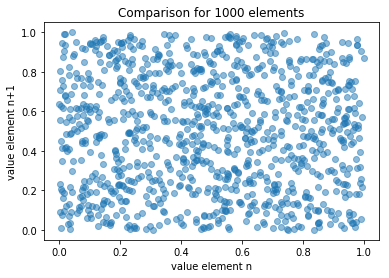

In [54]:
all_randnum = []
for i in range(1000):
    # Could vectorize? 
    all_randnum.append(RNGESUS.get_randomnumber())
    
plt.plot(all_randnum,np.roll(all_randnum,1),'o',alpha=0.5)
plt.title(f'Comparison for {len(all_randnum)} elements')
plt.xlabel('value element n')
plt.ylabel('value element n+1')
plt.savefig('q1b1.png')
plt.show();

Is np.linspace allowed?


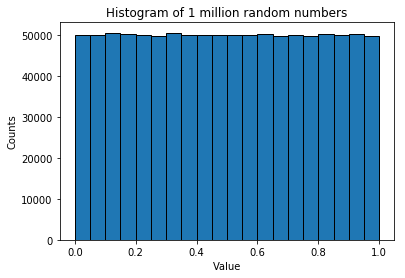

In [55]:
all_randnum = []
for i in range(int(1e6)):
    all_randnum.append(RNGESUS.get_randomnumber())
    
print( "Is np.linspace allowed?" )
plt.hist(all_randnum,bins=np.linspace(0,1,21),edgecolor='black')
plt.title(f'Histogram of 1 million random numbers')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.savefig('q1b2.png')
plt.show();

# Question 2

In [56]:
# Randomly generate a,b,c within asked bounds
a = RNGESUS.get_randomnumber()*(2.5-1.1) + 1.1
b = RNGESUS.get_randomnumber()*(2.0-0.5) + 0.5
c = RNGESUS.get_randomnumber()*(4-1.5) + 1.5

print (f'a, b, c = {a,b,c}')

a, b, c = (1.8850024988161098, 0.9551760426160483, 3.079176929083844)


In [82]:
def numbdensprofile(x, a, b, c, A=1, Nsat = 100, spherical=False):
    """
    Returns the number density profile from the assignment
    
    a controls small-scale slope
    b contols transition scale
    c controls steepness of exponential dropoff
    spherical -- True to multiply by x**2 for the spherical integral
    """
    if spherical:
        power = 1
    else:
        power = 3
        
    return A*Nsat * (x/b)**(a-power) * np.exp(-(x/b)**c)

In [83]:
def trapezoid(func,lbound,ubound,N=100,lb_open=False,ub_open=False):
    """
    Calculate the integral of a function using the trapezoid rule
    with equal spaced abscissae
    
    func    -- def   -- function which gives the y values
    lbound  -- float -- lower bound of integral
    ubound  -- float -- upper bound of integral
    N       -- int   -- number of abscissae
    lb_open -- bool  -- whether to include lower bound
    ub_open -- bool  -- whether to include upper bound
    
    """
    xvalues = np.linspace(lbound,ubound,N)
    delta_x = (ubound-lbound)/(N-1)    
    
    if lb_open: # skip lower bound, start at x1
        start_midpoint = 2
        integral = func(xvalues[1])*3/2
        
    else: # dont skip lower bound, start at x0
        integral = func(lbound)/2       
        start_midpoint = 1
    
    if ub_open:
        end_midpoint = -2
    else:
        end_midpoint = -1
    
    # all middle points
    for x in xvalues[start_midpoint:end_midpoint]:
        integral += func(x)
    
    if ub_open:
        integral += func(xvalues[-2])*(3/2)
    else: 
        integral += func(xvalues[-1])/2
        
    integral *= delta_x
    
    return integral
    

In [84]:
def extended_midpoint(func,lbound,ubound,N=100):
    """
    N is the number of abscissae, thus we have N-1 intervals
    """
    
    delta_x = (ubound-lbound)/(N-1)    
    # Equally spaces x values at the midpoints
    xvalues = np.arange(lbound+delta_x,ubound-delta_x,delta_x)
    
    # all points
    integral = 0
    for x in xvalues:
        integral += func(x)
    
    integral *= delta_x
    
#     Should still add first or last point depending on open/closed
    return integral

In [85]:
def simpsons(func, lbound, ubound, N=100):
    """
    Calculate the integral of a function using Simpsons rule
    with equal spaced abscissae
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    N      -- number of abscissae (N-1 intervals)
    
    """
    xvalues = np.linspace(lbound,ubound,N)
    delta_x = (ubound-lbound)/(N-1)
    # first point and last point 
    integral = func(lbound) + func(ubound)
    # all other points
    for i in range(1,N-1):
        # om en om 4 en 2, beginnen bij 4 als i=1
        if i % 2 == 0:            
            integral += 2*func(xvalues[i])
        else:
            integral += 4*func(xvalues[i])
    integral *= delta_x/3
    
    return integral
    

def open_simpsons(func, lbound, ubound, N=100, lb_closed=False, ub_closed=False):
    """
    Implementation of simpsons rule for possibly open intervals
    by default calculates open integral for both lower and upper bound
    Can close one of the bounds with lb_closed or ub_closed params
    
    see also def simpsons
    
    """
    
    # if both bounds are closed, just do normal simpsons
    if lb_closed and ub_closed:
        return simpsons(func,lbound,ubound,N)
    
    delta_x = (ubound-lbound)/(N-1)
    xvalues = np.linspace(lbound,ubound,N)
    
    if not lb_closed: # If lb open, first point is now x1 
        xvalues = xvalues[1:]
        
    if not ub_closed: # last point is N-1
        xvalues = xvalues[:-1]
        
    # coefficients
    if lb_closed: # if lb closed use 'normal' coefficients
        coefficients = [1,4,2,4] #x0 till x3
    else:
        coefficients = [27/4,0,13/4] #x1 till x3 
    for i in range(4,N-4): # go until N-3
        # 4 and 2 alternating
        if i % 2 == 0:
            coefficients.append(4)
        else:
            coefficients.append(2)
    
    if ub_closed: # if ub closed use 'normal' coefficients
        coefficients += [4,2,4,1] # N-3 to N
    else:
        coefficients += [13/4,0,27/4] # N-3 to N-1
        
    coefficients = np.asarray(coefficients)
    integral = delta_x/3 * np.sum(func(xvalues)*coefficients)
    
    return integral

In [86]:
def romberg(func, lbound, ubound, order=6):
    """
    Calculate the integral of a function using Romberg's method
    with equal spaced abscissae
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    N      -- number of abscissae
    
    efficiency:
    http://homen.vsb.cz/~lud0016/NM/Lecture_Notes_10-Romberg_Integration.pdf
    
    """
    
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)
    points = np.linspace(lbound,ubound,2**i+1)
    integral = delta_x/2 * np.sum(func(points))
    all_S[0,0] = integral
    
    # Then calculate the first column (S_{i,0})
    for i in range(1,order):
        delta_x /= 2
        # add points in the middle
        points = np.linspace(lbound,ubound,2**i+1)
        # add new points to the integral (om en om, starting from 1)
        integral = 0.5*integral + delta_x * np.sum(func(points[1::2]))
        
        all_S[i,0] = integral
    
    for j in range(1,order): # columns
        for i in range(j,order): # rows
            #print (i,j)
            #print (f'{4**j}*S{i},{j-1} - S{i-1},{j-1} / {4**j} - 1' )
            all_S[i,j] = (4**j*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           4**j -1)

    # compare this for the error function with the slides. 
    # print (all_S)
    
    return all_S[order-1,order-1]
        


In [87]:
def extended_romberg(func, lbound, ubound, order=6):
    """
    Calculate the integral of a function using Romberg's method
    with extended midpoints
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    N      -- number of abscissae
    
    """
    
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)/2
    # just the first midpoint
    points = np.array([ubound+delta_x])
    npoints = points
    integral = delta_x * func(points)
    
    all_S[0,0] = integral
    
    # Then calculate the first column (S_{i,0})
    for i in range(1,order):
        npoints *= 3
        delta_x = (ubound-lbound)/(npoints+1)
        # add points in the middle
        points = np.linspace(lbound+delta_x,ubound-delta_x,npoints)
        # add new points to the integral (om en om, starting from 0)
        integral = 0.5*integral + delta_x * np.sum(func(points[0::2]))
        
        all_S[i,0] = integral
    
    for j in range(1,order): # columns
        for i in range(j,order): # rows
            #print (i,j)
            #print (f'{4**j}*S{i},{j-1} - S{i-1},{j-1} / {4**j} - 1' )
            all_S[i,j] = (9*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           8)

    # compare this for the error function with the slides. 
    # print (all_S)
    
    return all_S[order-1,order-1]

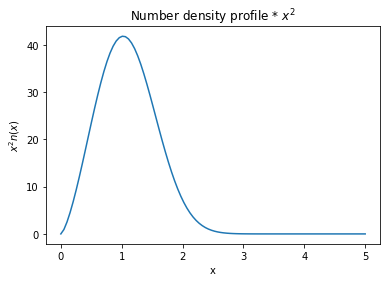

Trapezoid:
50.77330151645811
Romberg:
50.77466434102478
Extended midpoint:
50.77330151645811
Extended Romberg:
50.74293313779035
Open simpsons
50.770691384258555


/data1/osinga/miniconda/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [96]:
# For 
# a, b, c = (2.4545593364474785, 1.2954526977495828, 2.700255764586844)
a = 2.45#45593364474785
b = 1.29#54526977495828
c = 2.70#0255764586844
# 84.4941
# integrate quad: 84.4941064059743,

# WolframAlpha input:
# integrate ( 100 * (x/b)**(a-3) * exp(-(x/b)**c)  ) from 0 to 5 where a = 2.4545593364474785, b = 1.2954526977495828, c = 2.700255764586844

xs = np.linspace(0.001,5,100)
plt.plot(xs, numbdensprofile(xs, a, b, c,spherical=True))
plt.title('Number density profile * $x^2$')
plt.xlabel('x')
plt.ylabel('$x^2 n(x)$')
plt.show();

# integral is only a function of R so add the prefactor manually
prefactor = 4*np.pi # integral over theta and phi
print ("Trapezoid:")
print (trapezoid(lambda x:  numbdensprofile(x, a, b, c, spherical=True)
                 , 0, 5,N=100))

print ("Romberg:")
print (romberg(lambda x: numbdensprofile(x, a, b, c, spherical=True)
               , 0, 5,order=10))

print ("Extended midpoint:")
print (extended_midpoint(lambda x: numbdensprofile(x,a,b,c,spherical=True)
                         ,0,5,N=100))

print ("Extended Romberg:")
print (extended_romberg(lambda x: numbdensprofile(x, a, b, c,spherical=True)
                        , 0, 5,order=10))

print ("Open simpsons")
print (open_simpsons(lambda x: numbdensprofile(x, a, b, c,spherical=True)
                        , 0, 5,N=100,ub_closed=True,lb_closed=False))

print ()

In [97]:
# Randomly generate a,b,c within asked bounds
a = RNGESUS.get_randomnumber()*(2.5-1.1) + 1.1
b = RNGESUS.get_randomnumber()*(2.0-0.5) + 0.5
c = RNGESUS.get_randomnumber()*(4-1.5) + 1.5

print ("For the following ")
print (f'a, b, c = {a,b,c}')

print ("Extended midpoint rule gives:")
A = 1 / ( extended_midpoint(lambda x: x**2*numbdensprofile(x,a,b,c)
                         ,0,5,N=100))
print (f"A = {A}")

For the following 
a, b, c = (2.406248098879979, 1.8077650138126704, 3.918867584125613)
Extended midpoint rule gives:
A = 0.004550045901832884


### Make a loglog plot of and plot single points for n(1e-4), n(1e-2), n(1e-1), n(1) and n(5)

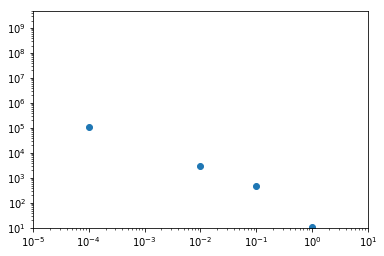

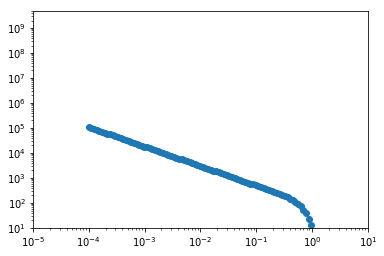

In [90]:
points = np.array([1e-4, 1e-2, 1e-1, 1, 5])
yvalues = numbdensprofile(points,a,b,c)
plt.scatter(points,yvalues)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-5,1e1)
plt.ylim(1e1,5e9)
plt.show();


# Testing
points = np.logspace(-4,0.7,100)
yvalues = numbdensprofile(points,a,b,c)
plt.scatter(points,yvalues)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-5,1e1)
plt.ylim(1e1,5e9)
plt.show();
